In [2]:
%matplotlib inline
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import stats


from biosppy.signals import tools as st
from biosppy.signals import eda
from biosppy.signals import ecg
from biosppy.signals import emg
from biosppy.signals import resp
from biosppy.signals import tools as st
from biosppy import plotting, utils

from scipy import signal

In [3]:
#ecg related function
def downsampling(signal,sampling_rate,new_rate):
    r=sampling_rate/new_rate
    n_signal=signal[range(0,len(signal),r)]
    rate=sampling_rate/(r*1.0)
    return {'sig':n_signal,'rate':rate}

def uni_hr(hr,hr_ts,ts):
    """resample and iterpolate to generate equal interval heart rate
    Require
    --------
    from scipy.interpolate import interp1d
    
    Parameter
    ---------
    hr : heart rate value
    hr_ts : heart rate time stamp
    ts : desired equal interval time stamp
    
    Returns
    -------
    hrn: equal interval heart rate
    """
    hrn=[None]*len(ts)
    hrn=np.array(hrn)
    hrn[ts >= hr_ts[-1]] = hr[-1]
    hrn[ts <= hr_ts[0]] = hr[0]
    last=np.nonzero(ts>=hr_ts[-1])
    le=list(last[0])[0]
    first=np.nonzero(ts<=hr_ts[0])
    fe=list(first[0])[-1]
    f = interp1d(hr_ts, hr)
    hrn[fe:le+1]=f(ts[range(fe,le+1)])
    hrn=[float(i) for i in hrn]
    return hrn
chunkdf=pd.read_csv('/home/wenlu/Documents/XPFIFA/biopacMatch/S16_m32.txt',sep='\t',nrows=240000,header=None,usecols=[0,1,2,3,5,6,7,8,9],names=['ts','rsp','x', 'emg_s','y','eda','ecg','z','emg_f'])


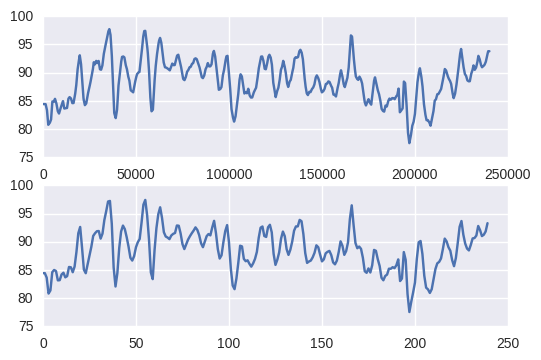

In [90]:
sig_ecg=chunkdf['ecg']
ts, filtered, rpeaks, templates_ts, templates, hr_ts,hr = ecg.ecg(signal=sig_ecg, sampling_rate=1000,show=False)
hre=np.array(uni_hr(hr,hr_ts,ts))
len(hre)
plt.subplot(2,1,1)
plt.plot(hre)
plt.subplot(2,1,2)
plt.plot(downsampling(np.array(hre),1000,1)['sig'])

In [ ]:
sig_emg=chunkdf['emg_s']
emb=sig_emg.rolling(window=2000, min_periods=1).apply(lambda x: np.mean(np.square(x)))
embd=downsampling(np.array(emb),1000,1)['sig']

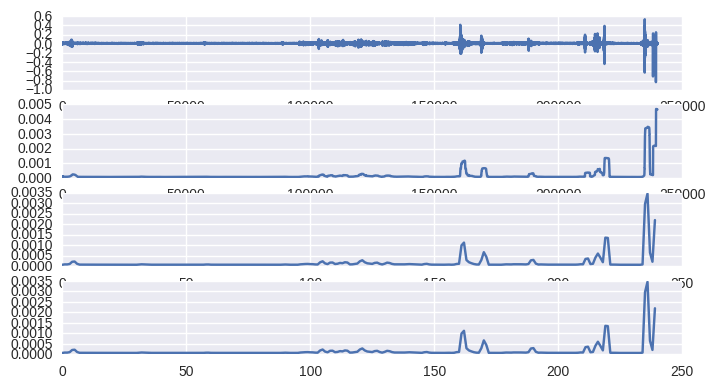

In [11]:
plt.subplot(5,1,1)
plt.plot(sig_emg)
plt.subplot(5,1,2)
plt.plot(emb)
plt.subplot(5,1,3)
plt.plot(embd)
plt.subplot(5,1,4)
plt.plot(np.tanh(embd))

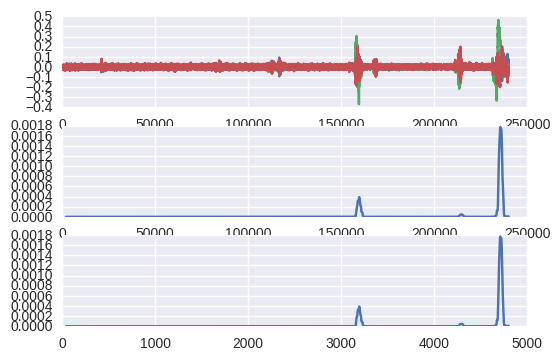

In [132]:
acc=chunkdf[['x','y','z']]
meansig=acc.rolling(window=2000, min_periods=1).mean()
acc=acc-meansig
at=acc.apply(lambda x: np.mean(np.square(x)),axis=1)
ats=at.rolling(window=2000).apply(lambda x: np.mean(np.square(x)))

plt.subplot(3,1,1)
plt.plot(acc)
plt.subplot(3,1,2)
plt.plot(ats)
plt.subplot(3,1,3)
plt.plot(downsampling(np.array(ats),1000,20)['sig'])


In [4]:
def prepro(chunkdf,freq=1000,sample_freq=20):
    def ecgpre(sig,freq,sample_freq):
        ts, filtered, rpeaks, templates_ts, templates, hr_ts,hr = ecg.ecg(signal=sig, sampling_rate=freq,show=False)
        hre=np.array(uni_hr(hr,hr_ts,ts))
        hrd=downsampling(np.array(hre),freq,sample_freq)['sig']
        return hrd
    def emgpre(sig,freq,sample_freq):
        emb=sig.rolling(window=2*freq, min_periods=1).apply(lambda x: np.mean(np.square(x)))
        embd=downsampling(np.array(emb),freq,sample_freq)['sig']
        return embd
    def accpre(sig,freq,sample_freq):
        meansig=sig.rolling(window=2000, min_periods=1).mean()
        acc=sig-meansig
        at=acc.apply(lambda x: np.mean(np.square(x)),axis=1)
        ats=at.rolling(window=2000, min_periods=1).apply(lambda x: np.mean(np.square(x)))
        accd=downsampling(np.array(ats),freq,sample_freq)['sig']
        return accd
    hr=ecgpre(chunkdf['ecg'],freq,sample_freq)
    emgf=emgpre(chunkdf['emg_f'],freq,sample_freq)
    emgs=emgpre(chunkdf['emg_s'],freq,sample_freq)
    acc=accpre(chunkdf[['x','y','z']],freq,sample_freq)
    eda=downsampling(chunkdf['eda'],freq,sample_freq)['sig']
    rsp=downsampling(chunkdf['rsp'],freq,sample_freq)['sig']
    processed=pd.DataFrame({'hr':hr,'emg_s':emgs,'emg_f':emgf,'acc':acc,'eda':eda,'rsp':rsp})
    return processed

In [5]:
dfAll = pd.read_csv('./../out/Allevent.txt',encoding='utf-16',index_col=0)
bioMatchPath="./../biopacMatch/"
outMatchPath="./../biopacMatchTrans/"
for sujet in range(20,59):
    for sequence in ['m11','m12','m21','m22','m31','m32']:
        fn='S'+str(sujet)+'_'+sequence+'.txt'
        matchFilename=bioMatchPath+fn
        #print fn
        try:
            chunkdf=pd.read_csv(matchFilename,sep='\t',nrows=240000,header=None,usecols=range(0,11),names=['ts','rsp', 'x', 'emg_s','skt','y','eda','ecg','z','emg_f','temp'])
            tmp=prepro(chunkdf,freq=1000,sample_freq=10)
            ofilename=outMatchPath+fn
            tmp.to_csv(ofilename,columns=['hr','rsp','eda','emg_f','emg_s','acc'],encoding='utf-16',index=False)
        except:
            print fn+' not found'
            continue

In [7]:
p=prepro(chunkdf,freq=1000,sample_freq=10)
p.head()

,acc,eda,emg_f,emg_s,hr,rsp
0,0.000000e+00,8.33282,0.000065,0.000063,65.059251,7.03217
100,1.424853e-09,8.33893,0.000038,0.000091,65.059251,6.99738
200,1.408976e-09,8.33282,0.000036,0.000092,65.059251,6.94336
300,1.706909e-09,8.32977,0.000037,0.000095,65.059251,6.88538
400,2.197003e-09,8.33435,0.000037,0.000089,65.059251,6.81183


In [8]:
p.to_csv("./../biopacMatchTrans/test",columns=['hr','rsp','eda','emg_f','emg_s','acc'],encoding='utf-16',index=False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ac5738a90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0ac5091210>], dtype=object)

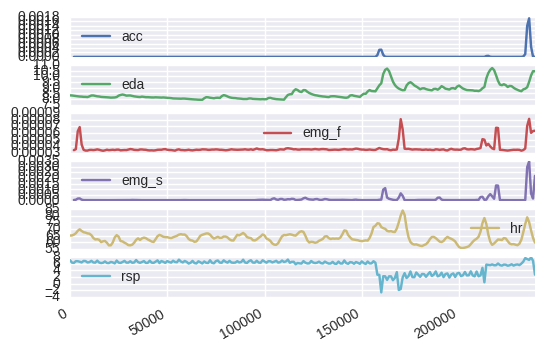

In [146]:
p.plot(subplots=True)

In [154]:
def ploteventtrait(plt, eventtmp):
    for index, row in eventtmp.iterrows():
        #mywidth=np.fabs(row['arousal'])+1
        if row['arousal']>0:
            pos_down = 0.5
            pos_up= 0.15 * row['arousal']
        else:
            pos_down = 0.5 + 0.15*row['arousal']-0.02
            pos_up= 0.5
        plt.axvline(row['rela_point']-300,color='r',ymin=pos_down, ymax=pos_up,linewidth=2)
        
    for index, row in eventtmp.iterrows():
        #mywidth=np.fabs(row['valence'])+1
        if row['valence']>0:
            pos_down = 0.5
            pos_up= 0.15 * row['valence']
        else:
            pos_down = 0.5 + 0.15*row['valence']-0.02
            pos_up= 0.5
        plt.axvline(row['rela_point']+300,color='g',ymin=pos_down, ymax=pos_up,linewidth=2)   
        
def plotseq(chunkdf,sujet, sequence,eventtmp):
    fig = plt.figure(figsize=(30,20))
    figurename='S'+str(sujet)+'_'+sequence
    fig.suptitle(figurename)
    gs = gridspec.GridSpec(7,1)
     # raw signal

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(range(l), chunkdf['ecg'], linewidth=1, label='ecg')
    #ax1.legend()
    ax1.set_ylabel('ECG')
    ploteventtrait(plt,eventtmp)

    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.plot(range(l), chunkdf['rsp'], linewidth=1, label='respiration')
    #ax2.legend()
    ax2.set_ylabel('Resp')
    ploteventtrait(plt,eventtmp)

    ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
    ax3.plot(range(l), chunkdf['eda'], linewidth=1, label='eda')
    #ax3.legend()
    ax3.set_ylabel('EDA')
    ploteventtrait(plt,eventtmp)

    ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
    ax4.plot(range(l), chunkdf['skt'], linewidth=1, label='skinTemp')
    #ax4.legend()
    ax4.set_ylabel('SkinTemp')
    ploteventtrait(plt,eventtmp)

    ax5 = fig.add_subplot(gs[4, 0], sharex=ax1)
    ax5.plot(range(l), chunkdf['emg_s'], linewidth=1, label='emg_s')
    #ax5.legend()
    ax5.set_ylabel('EMG_m')
    ploteventtrait(plt,eventtmp)

    ax6 = fig.add_subplot(gs[5, 0], sharex=ax1)
    ax6.plot(range(l), chunkdf['emg_f'], linewidth=1, label='emg_f')
    #ax6.legend()
    ax6.set_ylabel('EMG_f')
    ploteventtrait(plt,eventtmp)

    ax7 = fig.add_subplot(gs[6, 0], sharex=ax1)
    ax7.plot(range(l), chunkdf[['x','y','z']], linewidth=1)
    #ax7.legend(['x','y','z'])
    ax7.set_ylabel('Acce')
    ploteventtrait(plt,eventtmp)

    savename='./../plot/'+figurename+'.pdf'
    fig.savefig(savename,dpi=100)
    #plt.show()
    plt.close()    

In [ ]:
sujet = 19
sequence = 'm12'
bioMatchPath="./../biopacMatch/"
#Read Biopac files of selected sequence : exp: ./../biopacMatch/S4_m12.txt
matchFilename=bioMatchPath+"S"+str(sujet)+"_"+sequence+".txt"
print matchFilename
chunkdf=pd.read_csv(matchFilename,sep='\t',nrows=240000,header=None,usecols=range(0,11),names=['ts','rsp', 'x', 'emg_s','skt','y','eda','ecg','z','emg_f','temp'])
l=len(chunkdf)

#Get beginning timestamp (Absolute_sec) of selected sequence
strsujet = 'S'+str(sujet)
begin = Mdf[strsujet].ix[sequence,6]
end = Mdf[strsujet].ix[sequence,4]

#Get event list of selected sequence
eventtmp=dfAll.ix[(dfAll['sujet']==sujet) ,:]
eventtmp=eventtmp[(eventtmp.Absolute_sec>begin)&(eventtmp.Absolute_sec<end)]
eventtmp['rela_point']=pd.Series((eventtmp.Absolute_sec-begin)*sample_freq) #event point respect to the beginning timestamp
#eventtmp
plotseq(chunkdf,sujet,sequence,eventtmp)